In [1]:
import gymnasium as gym
from matplotlib import pyplot as plt
import re
import numpy as np
from tqdm.notebook import trange, tqdm
from math import floor

In [2]:

def row_col_to_seq(row_col, num_cols):
    '''
    Converts row_col to num_cols format

    Args:
        row_col (np.ndarray): Location of shape (1,2)
        num_cols (int): Total number of cols
    Return:
        (np.ndarray): Number format of row and column of shape (1,)
  '''
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols):
    '''
    Converts state number to rol_col format
    Args:
        seq (int): Number format of state
        num_cols (int): Number of columns
    Return:
        (np.ndarray): Array of shape (1,2) as [[row, col]]
    '''
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [3]:
DOWN = 0
UP = 1
LEFT = 3
RIGHT = 2
PICKUP = 4
DROP = 5

def policy_ep(q_values, state, ep):
    num_actions = q_values.shape[1]
    rand_num = np.random.random()
    if rand_num < ep:
        action = np.random.choice(np.arange(num_actions))
    else:
        action = np.argmax(q_values[state])

    return action



def plot_Q(Q, message = "Q plot"):

    fig = plt.figure(figsize=(6,5))
    plt.title(message, fontsize = 10)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2,  cmap = 'GnBu')
    c_bar = plt.colorbar()
    c_bar.ax.tick_params(labelsize= 8)
    def x_direct(a):
        if a in [UP, DOWN]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == RIGHT else -1
    def y_direct(a):
        if a in [RIGHT, LEFT]:
            return 0
        if a in [PICKUP, DROP]:
            return 0
        return 1 if a == UP else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    #plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

In [4]:
env = gym.make('Taxi-v3', render_mode = 'ansi')
s = env.reset()
# plt.imshow(env.render())
# plt.axis('off')
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [5]:
def left(env, state, counts):
    taxi_row, taxi_col, pass_curr_loc, dest_curr_idx = env.decode(state)

    optdone = False
    optact = 3
    if taxi_row == 0 and taxi_col == 2:
        optdone = True
    elif taxi_row == 1 and taxi_col == 2:
        optdone = True
    elif taxi_row == 3 and taxi_col == 1:
        optdone = True
    elif taxi_row == 4 and taxi_col == 1:
        optdone = True
    elif taxi_row == 3 and taxi_col == 3:
        optdone = True
    elif taxi_row == 4 and taxi_col == 3:
        optdone = True
    if counts >5:
        optdone = True
    
    return optact, optdone



def right(env, state, counts):
    taxi_row, taxi_col, pass_curr_loc, dest_curr_idx = env.decode(state)

    optdone = False
    optact = 2
    if taxi_row == 0 and taxi_col == 1:
        optdone = True
    elif taxi_row == 1 and taxi_col == 1:
        optdone = True
    elif taxi_row == 3 and taxi_col == 0:
        optdone = True
    elif taxi_row == 4 and taxi_col == 0:
        optdone = True
    elif taxi_row == 3 and taxi_col == 2:
        optdone = True
    elif taxi_row == 4 and taxi_col == 2:
        optdone = True
    if counts >5:
        optdone = True
    
    return optact, optdone

    

In [6]:
def train_smdp(num_episodes, env, printing = False):
    row = 5
    col = 5
    num_pass_loc = 5
    num_dest_loc = 4
    num_options = 4 # Goto R, G, Y, B
    num_primitive_act = 6
    num_states = 500
    tot_actions = num_primitive_act + num_options

    gamma = 0.9
    alpha = 0.1
    ep = 0.01

    q_val_actions = np.zeros((500,8)) #np.zeros((row*col, 8)) # shape (25,8)

    reward_epsiode_monitor = []
    num_steps_monitor = []

    for i in tqdm(range(num_episodes)):
        
        curr_state = env.reset()[0]
        #taxi_start_row, taxi_start_col, pass_loc, dest_idx = env.decode(curr_state)
        done = False
        steps = 0
        tot_reward = 0
        
        while not done:
            # Decoding state
            curr_row, curr_col, passcurr_loc, destcurr_idx = env.decode(curr_state)
            curr_state_seq = row_col_to_seq(np.array([[curr_row, curr_col]]), 5)

            # choose option
            action = policy_ep(q_val_actions, curr_state, ep)

            if action <6:
                next_state, reward, done, truncated, t_prob = env.step(action)
                next_row, next_col, passnext_loc, destnext_idx = env.decode(next_state)
                next_state_seq = row_col_to_seq(np.array([[next_row, next_col]]), 5)

                q_val_actions[curr_state, action] = q_val_actions[curr_state, action] + alpha * (reward + gamma * np.max(q_val_actions[next_state]) - q_val_actions[curr_state, action])
                # q_val_actions[curr_state_seq, action] = q_val_actions[curr_state_seq, action] + alpha * (reward + gamma * np.max(q_val_actions[next_state_seq]) - q_val_actions[curr_state_seq, action])
                curr_state = next_state
                steps +=1
                tot_reward += reward

            if action == 6:
                # Move left
                optdone = False
                reward_bar = 0
                k = 0
                start_state = curr_state
                while not optdone:
                    optact, optdone = left(env = env, state = curr_state, counts = k)
                    next_state, reward, done, truncated, t_prob = env.step(optact)
                    reward_bar = gamma * reward_bar + reward
                    tot_reward += reward
                    curr_state = next_state
                    k +=1
                    steps +=1

                    if optdone:
                        terminal_state = next_state
                # start
                start_row, start_col, passstart_loc, deststart_idx = env.decode(start_state)
                start_state_seq = row_col_to_seq(np.array([[start_row, start_col]]), 5)
                # Terminal
                terminal_row, terminal_col, passterminal_loc, destterminal_idx = env.decode(terminal_state)
                terminal_state_seq = row_col_to_seq(np.array([[terminal_row, terminal_col]]), 5)

                # q_val_actions[start_state_seq, action] = q_val_actions[start_state_seq, action] + alpha * (reward_bar + (gamma **k) * np.max(q_val_actions[terminal_state_seq])- q_val_actions[start_state_seq, action])
                q_val_actions[start_state, action] = q_val_actions[start_state, action] + alpha * (reward_bar + (gamma **k) * np.max(q_val_actions[terminal_state])- q_val_actions[start_state, action])

            if action == 7:
                # move right
                optdone = False
                reward_bar = 0
                k = 0
                start_state = curr_state
                while not optdone:
                    optact, optdone = right(env = env, state = curr_state, counts = k)
                    next_state, reward, done, truncated, t_prob = env.step(optact)
                    reward_bar = gamma * reward_bar + reward
                    tot_reward += reward
                    curr_state = next_state
                    k +=1
                    steps +=1

                    if optdone:
                        terminal_state = next_state
                # start
                start_row, start_col, passstart_loc, deststart_idx = env.decode(start_state)
                start_state_seq = row_col_to_seq(np.array([[start_row, start_col]]), 5)
                # Terminal
                terminal_row, terminal_col, passterminal_loc, destterminal_idx = env.decode(terminal_state)
                terminal_state_seq = row_col_to_seq(np.array([[terminal_row, terminal_col]]), 5)

                # q_val_actions[start_state_seq, action] = q_val_actions[start_state_seq, action] + alpha * (reward_bar + (gamma **k) * np.max(q_val_actions[terminal_state_seq])- q_val_actions[start_state_seq, action])
                q_val_actions[start_state, action] = q_val_actions[start_state, action] + alpha * (reward_bar + (gamma **k) * np.max(q_val_actions[terminal_state])- q_val_actions[start_state, action])

        reward_epsiode_monitor.append(tot_reward)
        num_steps_monitor.append(steps)
        if printing:
            print(f'ep = {i}, steps = {steps}')
    return reward_epsiode_monitor, num_steps_monitor, q_val_actions

In [7]:
num_runs = 5
num_episodes = 5000
rew_monitor = np.zeros((num_runs, num_episodes))
steps_monitor = np.zeros((num_runs, num_episodes))

for i in range(num_runs):
    env = gym.make('Taxi-v3')
    env.reset()
    rew, steps, _ = train_smdp(env = env, num_episodes = num_episodes)
    rew_monitor[i] = rew
    steps_monitor[i] = steps

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\chari\anaconda3\envs\dl_assignment\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0, 0.5, 'Reward')

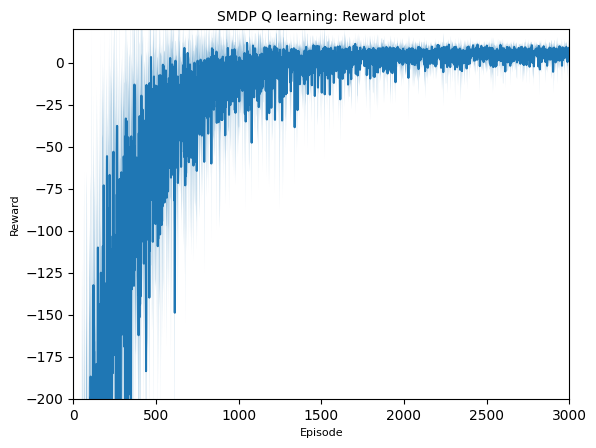

In [8]:
mean_rew = np.mean(rew_monitor, axis = 0)
se_rew = np.std(rew_monitor, axis = 0)
plt.plot(mean_rew)
plt.fill_between(np.arange(5000), 
                 mean_rew - se_rew, 
                 mean_rew + se_rew, 
                 alpha = 0.5)
plt.ylim(-200,20)
plt.xlim(0,3000)
plt.title('SMDP Q learning: Reward plot', fontsize = 10)
plt.xlabel('Episode', fontsize = 8)
plt.ylabel('Reward', fontsize = 8)

In [9]:
import pickle
with open('Reward_SMDP_newopt.pkl', 'wb') as file:
    pickle.dump(rew_monitor, file)
#file.close()